In [ ]:
import os, glob
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.layers import concatenate, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam


In [ ]:
labels_diction = {
    'Bacterial leaf blight': 0,
    'Brown spot': 1,
    'Leaf smut': 2,

}


In [ ]:
data_dir = '/content/drive/MyDrive/rice_leaf_diseases'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/rice_leaf_diseases'

X = []
y = []
for folder in os.listdir(data_dir):
    label = labels_diction[folder]
    for image in os.listdir(os.path.join(data_dir, folder)):
        image_path = os.path.join(data_dir, folder, image)
        img = cv2.imread(image_path)
        img = cv2.resize(img, (227, 227))
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
# Data augmentation
#datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X, y, batch_size=32)


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

In [ ]:
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(labels_diction), activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compiling the model
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)  # You might need other augmentations here if used during training
test_generator =test_datagen.flow(X, y, batch_size=32)

In [ ]:
# Training the model
#history = model.fit(train_generator, epochs=20, validation_data=(X, y))
history = model.fit(
    datagen.flow(X, y, batch_size=32),
    epochs=20,  # Increase epochs
    validation_data=(X, y)  # Use the separate validation set instead of training set for validation
)

Epoch 1/20
4/4 [==============================] - 47s 12s/step - loss: 2.1819 - accuracy: 0.3917 - val_loss: 17.1076 - val_accuracy: 0.3583
Epoch 2/20
4/4 [==============================] - 38s 11s/step - loss: 1.0702 - accuracy: 0.5500 - val_loss: 43.9934 - val_accuracy: 0.3333
Epoch 3/20
4/4 [==============================] - 59s 18s/step - loss: 0.6343 - accuracy: 0.7250 - val_loss: 23.4976 - val_accuracy: 0.3833
Epoch 4/20
4/4 [==============================] - 38s 11s/step - loss: 0.5707 - accuracy: 0.7333 - val_loss: 17.9507 - val_accuracy: 0.3083
Epoch 5/20
4/4 [==============================] - 37s 10s/step - loss: 0.4764 - accuracy: 0.8083 - val_loss: 25.1641 - val_accuracy: 0.3250
Epoch 6/20
4/4 [==============================] - 38s 11s/step - loss: 0.4799 - accuracy: 0.8083 - val_loss: 27.4979 - val_accuracy: 0.3583
Epoch 7/20
4/4 [==============================] - 33s 10s/step - loss: 0.4450 - accuracy: 0.8000 - val_loss: 17.9903 - val_accuracy: 0.3333
Epoch 8/20
4/4 [====

4/4 [==============================] - 18s 4s/step - loss: 0.0997 - accuracy: 0.9833
Test loss: 0.09973751753568649
Test accuracy: 0.9833333492279053


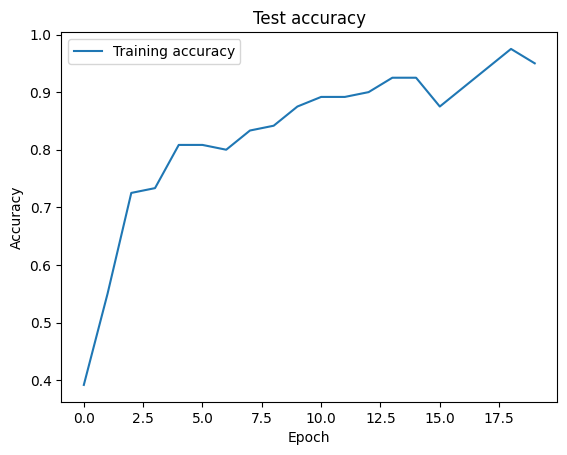

In [ ]:
# train_loss, train_accuracy = model.evaluate(X, y)
# print('Train loss:', train_loss)
# print('Train accuracy:', train_accuracy)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)  # Assuming you have a separate test generator
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

# Plot the training accuracy graph
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.title('Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Saving the model
model.save('rice_leaf_diseases_model_inceptionv3.h5')

In [ ]:
# Loading the model
new_model = tf.keras.models.load_model('rice_leaf_diseases_model_inceptionv3.h5')

In [ ]:
# Predicting on a new image
import PIL
image_path = '/content/drive/MyDrive/rice_leaf_diseases/Bacterial leaf blight/DSC_0367.JPG'
test_image = PIL.Image.open(image_path)
resized_image = test_image.resize((227, 227))
resized_image = np.array(resized_image) / 255.0
resized_image = resized_image[np.newaxis, ...]
prediction = new_model.predict(resized_image)
predicted_class_index = np.argmax(prediction)
#Print the predicted class index and check it
print('Predicted class index:', predicted_class_index)

# Map predicted class index to the actual label using the dictionary
predicted_label = {v: k for k, v in labels_diction.items()}.get(predicted_class_index)
print('Predicted label:', predicted_label)

1/1 [==============================] - 3s 3s/step
Predicted class index: 0
Predicted label: Bacterial leaf blight
